### Problem Statement

Given a dataset of Fake and real news, develop a solution which detects if a given news is fake or real.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import urllib
import json
import re
from wordcloud import WordCloud

### Data Preprocessing and Analysis

In [2]:
def convert_data(url):
    with urllib.request.urlopen(url) as url:
        df = json.loads(url.read().decode())
        df = pd.DataFrame.from_dict(df)
    return df
real_news_train = convert_data("https://storage.googleapis.com/public-resources/dataset/real_train.json")
fake_news_train = convert_data("https://storage.googleapis.com/public-resources/dataset/fake_train.json")

real_news_test = convert_data("https://storage.googleapis.com/public-resources/dataset/real_test.json")
fake_news_test = convert_data("https://storage.googleapis.com/public-resources/dataset/fake_test.json")

print(real_news_train.shape)
print(fake_news_train.shape)
print(real_news_test.shape)
print(fake_news_test.shape)

print(real_news_train.columns)
real_news_train.head()

(800, 3)
(800, 3)
(200, 3)
(200, 3)
Index(['url', 'title', 'text'], dtype='object')


,url,title,text
0,https://www.thetimes.co.uk/edition/scotland/sc...,Scots GPs told not to meet fever patients as f...,Scots GPs told not to meet fever patients as f...
1,https://www.bbc.com/news/world-africa-52103799,Coronavirus : Fighting al - Shabab propaganda ...,Coronavirus: Fighting al-Shabab propaganda in ...
2,https://www.thetimes.co.uk/edition/business/en...,Engineer fears China virus impact,Engineer fears China virus impact\nA British e...
3,https://www.theguardian.com/world/live/2020/fe...,Coronavirus : South Korean PM vows swift act...,Here’s a summary of what’s happened so far on ...
4,https://yle.fi/uutiset/osasto/news/finnair_iss...,Finnair issues profit warning over Covid - 19 ...,Finnair issues profit warning over Covid-19 fe...


In [3]:
real_news_train['label'] = 0
real_news_test['label'] = 0
fake_news_train['label'] = 1
fake_news_test['label'] = 1

train = pd.concat([real_news_train,fake_news_train],ignore_index=True)
test = pd.concat([real_news_test,fake_news_test],ignore_index=True)
print(train.shape)
print(test.shape)
print(train.columns)
train.head()

(1600, 4)
(400, 4)
Index(['url', 'title', 'text', 'label'], dtype='object')


,url,title,text,label
0,https://www.thetimes.co.uk/edition/scotland/sc...,Scots GPs told not to meet fever patients as f...,Scots GPs told not to meet fever patients as f...,0
1,https://www.bbc.com/news/world-africa-52103799,Coronavirus : Fighting al - Shabab propaganda ...,Coronavirus: Fighting al-Shabab propaganda in ...,0
2,https://www.thetimes.co.uk/edition/business/en...,Engineer fears China virus impact,Engineer fears China virus impact\nA British e...,0
3,https://www.theguardian.com/world/live/2020/fe...,Coronavirus : South Korean PM vows swift act...,Here’s a summary of what’s happened so far on ...,0
4,https://yle.fi/uutiset/osasto/news/finnair_iss...,Finnair issues profit warning over Covid - 19 ...,Finnair issues profit warning over Covid-19 fe...,0


In [4]:
train['text'][0]

'Scots GPs told not to meet fever patients as fears of coronavirus outbreak grow\nDoctors have been told to avoid meeting patients with symptoms such as a fever or respiratory infection under guidance drawn up by Scottish health officials, to prevent an outbreak of coronavirus.\nHealth Protection Scotland issued updated advice on Thursday amid concern that the virus, covid-19, is likely to surface in the UK.\nAn 80-year-old Chinese man who died in a French hospital was confirmed yesterday as the first casualty of the epidemic outside Asia.\nThe Scottish guidance states that GPs must avoid contact with any patient who phones in with symptoms including fever or respiratory infection. “Clinical and travel history should be obtained and triage completed by telephone wherever possible. Contact with the patient should be avoided: this includes avoidance of face-to-face consultation and examination,”'

In [5]:
def clean_txt(text):
    text = re.sub("'", "", text)
    text = re.sub("(\\W)+", " ", text)
    text = text.lower()
    return text
train['text'] = train['text'].apply(clean_txt)
test['text'] = test['text'].apply(clean_txt)
train['text'][0]

'scots gps told not to meet fever patients as fears of coronavirus outbreak grow doctors have been told to avoid meeting patients with symptoms such as a fever or respiratory infection under guidance drawn up by scottish health officials to prevent an outbreak of coronavirus health protection scotland issued updated advice on thursday amid concern that the virus covid 19 is likely to surface in the uk an 80 year old chinese man who died in a french hospital was confirmed yesterday as the first casualty of the epidemic outside asia the scottish guidance states that gps must avoid contact with any patient who phones in with symptoms including fever or respiratory infection clinical and travel history should be obtained and triage completed by telephone wherever possible contact with the patient should be avoided this includes avoidance of face to face consultation and examination '

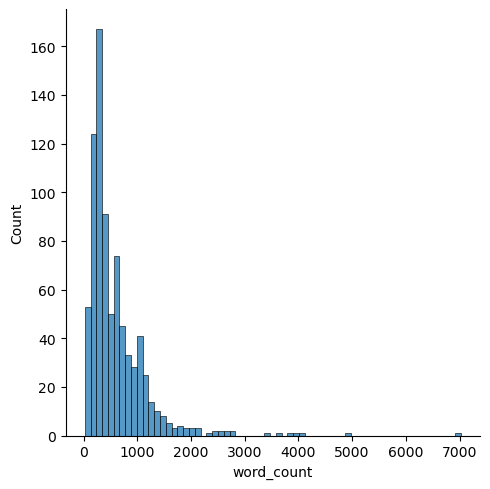

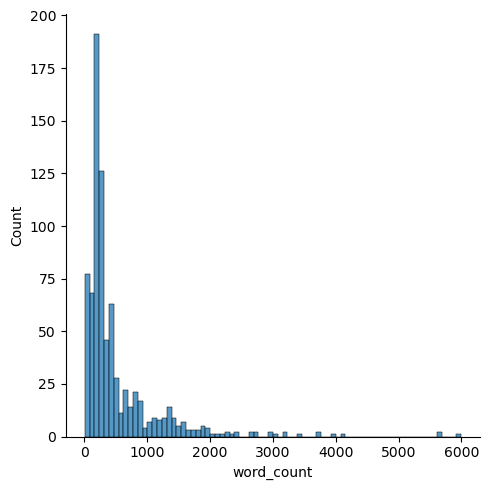

In [6]:
#Word Count histogram
train['word_count'] = [len(s.split()) for s in train['text']]
sns.displot(train['word_count'][train['label'] == 0],kde=False,rug=False)
sns.displot(train['word_count'][train['label'] == 1 & (train['word_count'] < 20000)],kde=False,rug=False)
# the word count distribution of fake news are more skewed

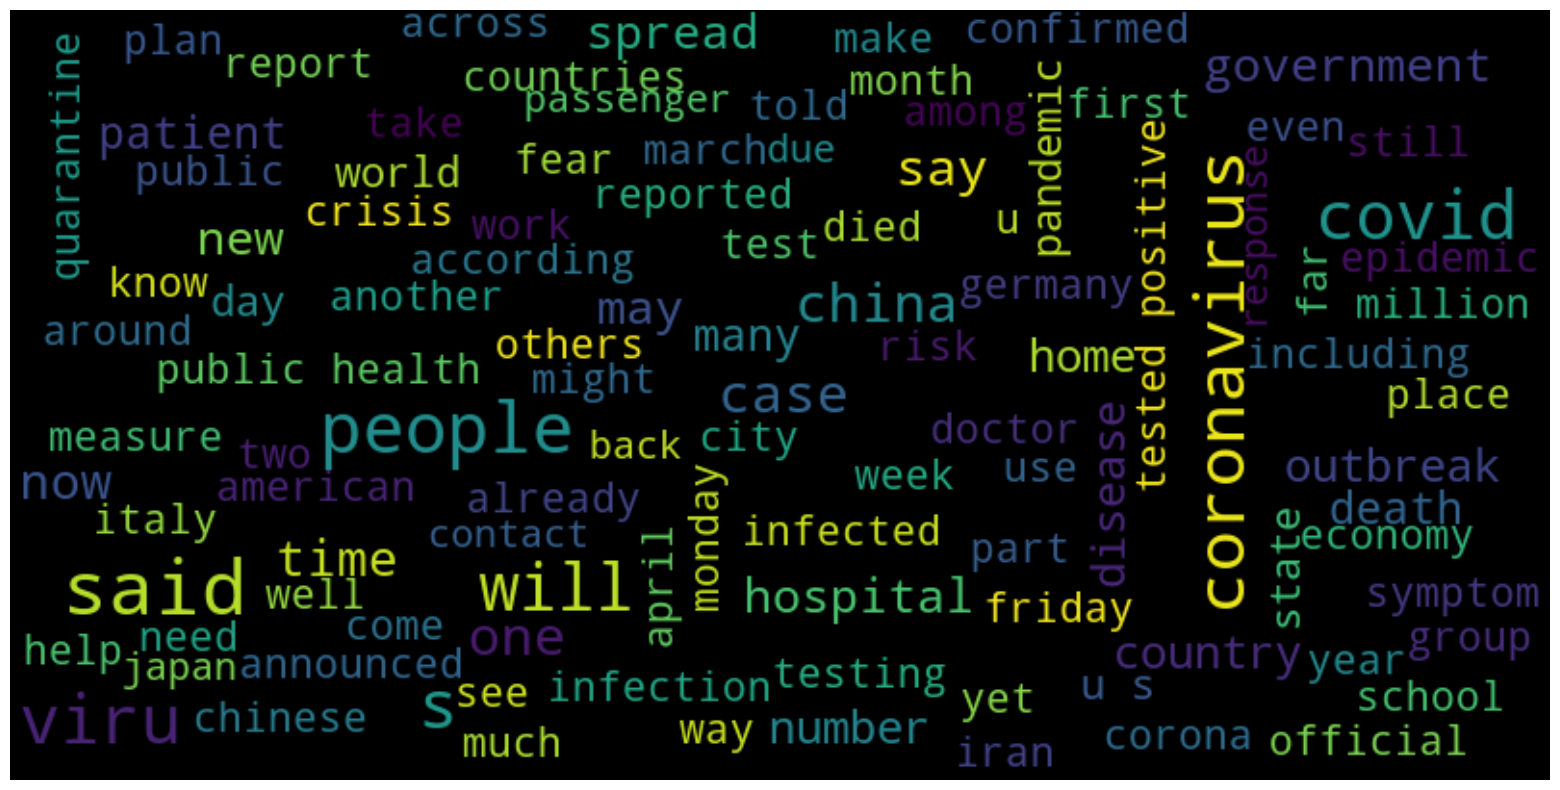

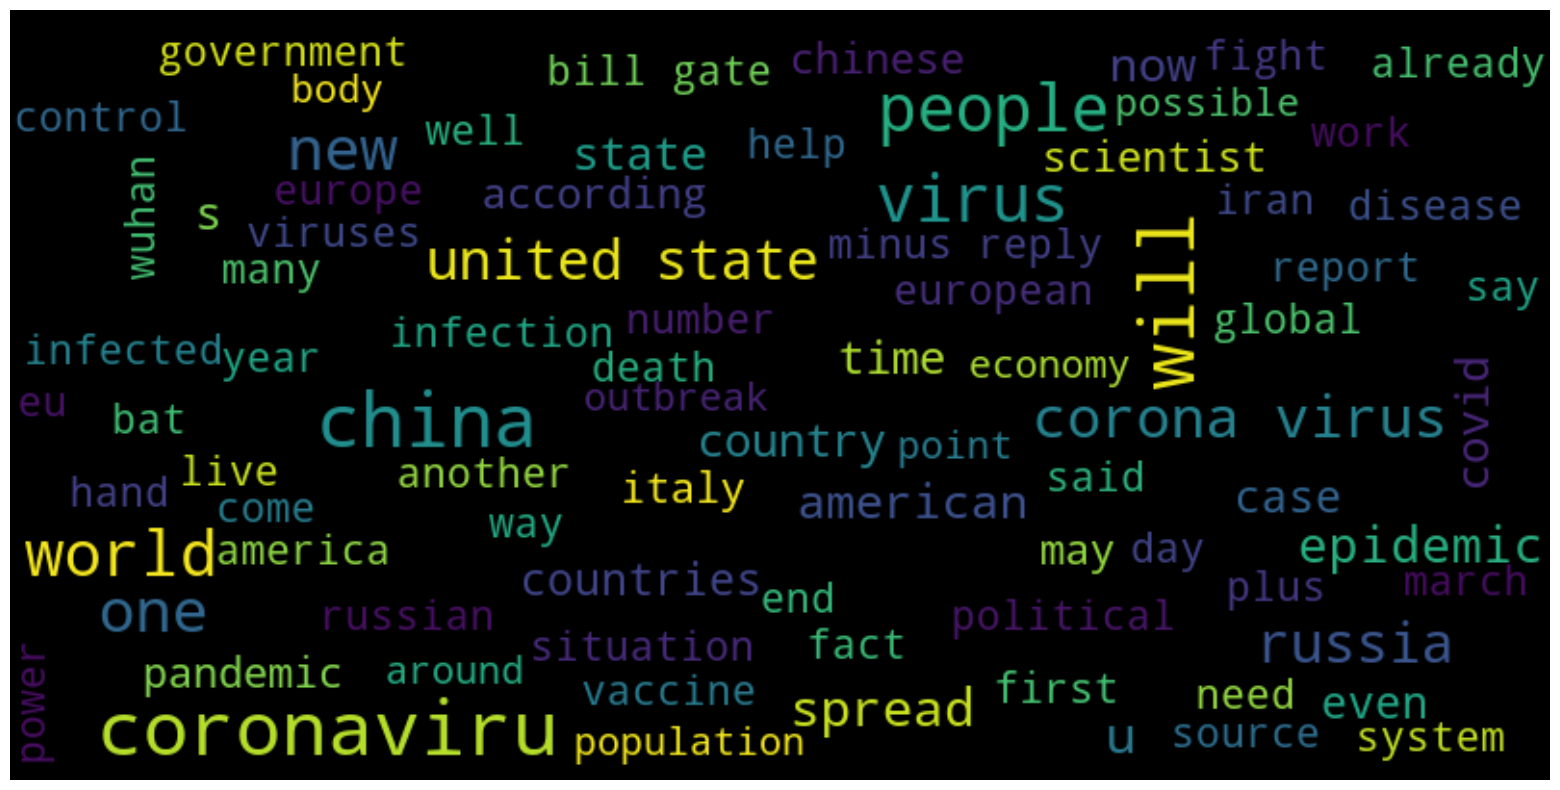

In [7]:
#Word Cloud
def plot_wordcloud(target,width=800,height=400):
    if target == 'real':
        t = 0
    elif target == 'fake':
        t = 1
    text = ''
    for t in train['text'][train['label'] == t]:
        text +=t
    wordcloud = WordCloud(max_font_size=40, min_font_size=20, width=800, height = 400, random_state=0).generate(text)
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
plot_wordcloud('real',width=600,height=300)
plot_wordcloud('fake',width=600,height=300)
# real: COVID 19, countries name and neutural words

In [9]:
#TopK words
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

#Concat the news into one document and split it into a list
def concat_text(target):
    if target == 'real':
        t = 0
    elif target == 'fake':
        t = 1
    text = ''
    for t in train['text'][train['label'] == t]:
        text +=t
    text = text.split()
    return text

#Calculate and order the vocab by its frequency.
def most_frequent_words(text):
    ngram_vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1), min_df=1)
    X = ngram_vectorizer.fit_transform(text)
    vocab = np.array(list(ngram_vectorizer.get_feature_names_out()))
    counts = np.array(X.sum(axis=0).A1)
    inds = counts.argsort()[::-1]
    ordered_vocab = vocab[inds]
    return ordered_vocab

real_text = concat_text('real')
fake_text = concat_text('fake')

real_vocab = most_frequent_words(real_text)
fake_vocab = most_frequent_words(fake_text)

print(real_vocab)
print(fake_vocab)

['the' 'to' 'of' ... 'injected' 'inject' '野味']
['the' 'of' 'and' ... 'figuratively' 'regulator' '٧١']


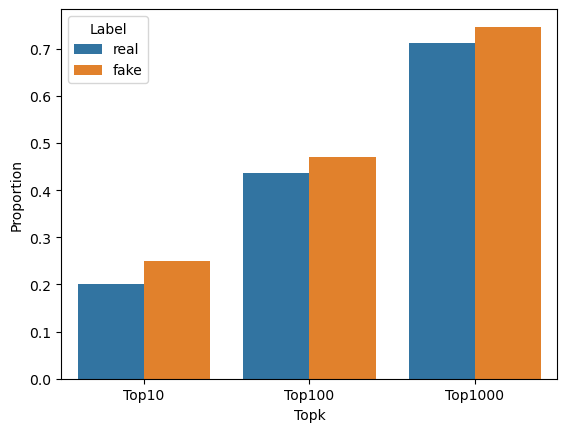

In [10]:
t1 = 10
t2 = 100
t3 = 1000
x = ['Top'+str(t1),'Top' + str(t2), 'Top' + str(t3)]
y = [np.mean([c in real_vocab[0:t1] for c in real_text]),
     np.mean([c in real_vocab[0:t2] for c in real_text]),
     np.mean([c in real_vocab[0:t3] for c in real_text]),
     np.mean([c in fake_vocab[0:t1] for c in fake_text]),
     np.mean([c in fake_vocab[0:t2] for c in fake_text]),
     np.mean([c in fake_vocab[0:t3] for c in fake_text])]
label = ['real','real','real','fake','fake','fake']
df = pd.DataFrame(zip(x*2, label, y), columns=["Topk", "Label", "Proportion"])
sns.barplot(x="Topk", hue="Label", y="Proportion", data=df)
plt.show()

### Splitting Data to Train/Validation

In [11]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, test_size=0.2, random_state=35)
print(train.shape)
print(val.shape)

(1280, 5)
(320, 5)


### Document Preprocessing

In [12]:
train['text'][1]

'coronavirus fighting al shabab propaganda in somalia muslim clerics in conflict hit somalia are moving to the front line of the battle against coronavirus in a bid to counter the propaganda of militant islamists writes bbc somalia analyst mary harper the al qaeda linked al shabab group has warned muslims to beware of infectious diseases such as coronavirus which it says are spread by the crusader forces who have invaded the country and the disbelieving countries that support them the militants control much of southern and central somalia and have been a powerful force for well over a decade although there have only been a handful of confirmed cases of coronavirus in somalia so far the authorities are deeply worried that if the disease takes hold they will be unable to cope koranic schools shut about 30 years of conflict have devastated health facilities hundreds of thousands of displaced people are crowded into camps with limited access to soap and water and no way of practising socia

In [13]:
def get_split(text):
    total = []
    partial = []
    if len(text.split())//120 > 0:
        n = len(text.split())//120
    else:
        n = 1
    for i in range(n):
        if i == 0:
            partial = text.split()[:150]
            total.append(" ".join(partial))
        else:
            partial = text.split()[i*120:i*120+150]
            total.append(" ".join(partial))
    return total
train['text_split'] = train['text'].apply(get_split)
val['text_split'] = val['text'].apply(get_split)
test['text_split'] = test['text'].apply(get_split)

train['text_split'][1]

['coronavirus fighting al shabab propaganda in somalia muslim clerics in conflict hit somalia are moving to the front line of the battle against coronavirus in a bid to counter the propaganda of militant islamists writes bbc somalia analyst mary harper the al qaeda linked al shabab group has warned muslims to beware of infectious diseases such as coronavirus which it says are spread by the crusader forces who have invaded the country and the disbelieving countries that support them the militants control much of southern and central somalia and have been a powerful force for well over a decade although there have only been a handful of confirmed cases of coronavirus in somalia so far the authorities are deeply worried that if the disease takes hold they will be unable to cope koranic schools shut about 30 years of conflict have devastated health facilities hundreds of thousands of displaced people',
 'that if the disease takes hold they will be unable to cope koranic schools shut about 

In [14]:
def new_data_frame(df, df_name):
    text,label,index = [],[],[]
    for idx,row in df.iterrows():
        for l in row['text_split']:
            text.append(l)
            label.append(row['label'])
            index.append(idx)
    new_df = pd.DataFrame({'text': text,'label':label,'index':index})
    print("The " + df_name +" set now has " + str(len(new_df)) + ' subtexts extracted from ' + str(len(df)) + ' texts.')
    return new_df
train_df = new_data_frame(train, df_name = 'train set')
val_df = new_data_frame(val, df_name = 'validation set')
test_df = new_data_frame(test, df_name = 'test set')
train_df.shape

The train set set now has 5621 subtexts extracted from 1280 texts.
The validation set set now has 1305 subtexts extracted from 320 texts.
The test set set now has 1568 subtexts extracted from 400 texts.


(5621, 3)